# In this notebook we did:

  - evaluate and compare the performance of Logistic Regression and Random Forest models on a Pancancer dataset.
  - visualize further graphs with using ALL 1463 features.
  - the dataset contains 1463 proteins as features (input variables) and 1477 samples (data points).

In [1]:
# Import the packages we may need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from scipy.stats import sem
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import os
import time  # Import the time module




In [2]:
# Read in the pancancer dataset
Pancancer_df=pd.read_csv("pancancer.csv")

In [3]:
# Check what it looks like
Pancancer_df = pd.DataFrame(Pancancer_df)
Pancancer_df.head(5)

,Sample_ID,Cancer,Assay,OlinkID,UniProt,Panel,NPX
0,AML_1,AML,AARSD1,OID21311,Q9BTE6,Oncology,5.01745
1,AML_2,AML,AARSD1,OID21311,Q9BTE6,Oncology,2.86790
2,AML_3,AML,AARSD1,OID21311,Q9BTE6,Oncology,4.58825
3,AML_4,AML,AARSD1,OID21311,Q9BTE6,Oncology,1.97255
4,AML_5,AML,AARSD1,OID21311,Q9BTE6,Oncology,3.45995


In [4]:
# convert the NPX to numaric data type in order to use pivot_table later
Pancancer_df['NPX'] = pd.to_numeric(Pancancer_df['NPX'], errors='coerce')

In [5]:
# remove the quote mark
Pancancer_df[["Sample_ID","Cancer","UniProt"]] = Pancancer_df[["Sample_ID","Cancer","UniProt"]].apply(lambda x: x.str.replace('"', '', regex=False))
Pancancer_df.head(5)

,Sample_ID,Cancer,Assay,OlinkID,UniProt,Panel,NPX
0,AML_1,AML,AARSD1,OID21311,Q9BTE6,Oncology,5.01745
1,AML_2,AML,AARSD1,OID21311,Q9BTE6,Oncology,2.86790
2,AML_3,AML,AARSD1,OID21311,Q9BTE6,Oncology,4.58825
3,AML_4,AML,AARSD1,OID21311,Q9BTE6,Oncology,1.97255
4,AML_5,AML,AARSD1,OID21311,Q9BTE6,Oncology,3.45995


In [6]:
Pancancer_pivot = Pancancer_df.pivot_table(index = ['Sample_ID', 'Cancer'], columns = 'UniProt', values = 'NPX' )
Pancancer_pivot.reset_index(inplace=True)
Pancancer_pivot.head(15)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,AML,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,AML,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,AML,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,AML,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,AML,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
5,AML_14,AML,0.08920,0.22545,-0.47415,1.83150,0.92420,6.56080,4.30555,0.92640,...,5.56885,2.46510,1.82050,6.14920,5.99445,1.44280,5.41060,0.41685,3.25440,1.09110
6,AML_15,AML,-0.07185,0.10130,-1.39720,3.05240,1.26085,5.36945,1.55795,2.40705,...,1.48585,2.23725,0.15615,2.42300,4.81290,0.49115,2.69765,0.45220,1.49335,1.31605
7,AML_16,AML,0.64490,-0.00030,-1.52450,0.76560,1.11520,1.03430,0.93625,2.18410,...,2.53005,1.27950,-0.38825,0.62780,2.90270,0.30915,1.44680,0.46245,1.34865,0.24400
8,AML_17,AML,0.11200,0.84130,-0.81540,0.51790,2.04955,1.60310,3.77460,-0.22100,...,NaN,NaN,1.16780,NaN,NaN,1.61305,2.62540,0.03750,2.35580,NaN
9,AML_18,AML,0.97170,0.61700,-1.53600,0.22060,1.15250,1.96905,-0.01260,3.56180,...,3.79465,1.84825,0.11195,0.87955,3.94285,-0.40650,1.03135,0.24875,2.67350,1.88915


In [7]:
# Combine all the blood cancers into one category
df_bloodcombined = Pancancer_pivot.copy(deep = True)
df_bloodcombined = df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )

In [8]:
df_bloodcombined.head(5)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,BLOOD,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,BLOOD,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,BLOOD,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,BLOOD,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,BLOOD,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [9]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC'}

In [10]:
# Specify the protein list 
proteins=df_bloodcombined.columns[2:]
# Check that we have the right number of proteins
proteins

Index(['A1E959', 'A1L4H1', 'A4D1B5', 'A6NI73', 'B1AKI9', 'NTproBNP', 'O00161',
       'O00175', 'O00182', 'O00186',
       ...
       'Q9Y653', 'Q9Y662', 'Q9Y680', 'Q9Y6A5', 'Q9Y6D9', 'Q9Y6E0', 'Q9Y6K9',
       'Q9Y6N7', 'Q9Y6Q6', 'Q9Y6Y9'],
      dtype='object', name='UniProt', length=1463)

In [11]:
# Encode the cancer types as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bloodcombined['Cancer'] = le.fit_transform(df_bloodcombined['Cancer'])

In [12]:
df_bloodcombined.head(5)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,0,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,0,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,0,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,0,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [13]:
# Split the data into X and y
X = df_bloodcombined[proteins]
y = df_bloodcombined['Cancer']

In [14]:
df_bloodcombined.Cancer.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size=0.2, random_state=100)

In [16]:
# Cross-validation parameters
n_splits = 5  # Number of folds
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
# Initialize KNNImputer for handling missing values
imputer = KNNImputer(n_neighbors=5, weights="uniform")
smote = SMOTE(random_state=100)

In [17]:
# Check number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

# Set n_jobs based on available CPU cores (adjust as needed)
n_jobs = num_cores if num_cores > 4 else 4  # Use all cores if > 4, else use 4 for stability

Number of CPU cores available: 10


In [18]:

# Define models (Logistic Regression and Random Forest)
models = {
    "Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100)
}

In [19]:
# Number of features (proteins)
num_features = len(X_train.columns)
#num_features = 50

In [23]:
##Main code 

import time  # Import the time module


# Record the start time
start_time = time.time()

# Initialize arrays for scores
log_accuracy_score = np.zeros((num_features, 5))
log_F1 = np.zeros((num_features, 5))
log_AUC = np.zeros((num_features, 5))
log_gmean = np.zeros((num_features, 5))
log_recall = np.zeros((num_features, 5))
log_precision = np.zeros((num_features, 5))

rf_accuracy_score = np.zeros((num_features, 5))
rf_F1 = np.zeros((num_features, 5))
rf_AUC = np.zeros((num_features, 5))
rf_gmean = np.zeros((num_features, 5))
rf_recall = np.zeros((num_features, 5))
rf_precision = np.zeros((num_features, 5))

# For Logistic Regression and Random Forest models, iterate over the folds
def evaluate_model(fold_idx, train_index, test_index, X_train, y_train, imputer, smote, models, num_features):
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Convert X_fold_test_imputed back to a pandas DataFrame
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Apply SMOTE
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # Convert resampled_X back to a pandas DataFrame
    resampled_X = pd.DataFrame(resampled_X, columns=X_fold_train.columns)

    # Arrays to store metrics for this fold
    fold_log_metrics = np.zeros((num_features, 6))  # 6 metrics
    fold_rf_metrics = np.zeros((num_features, 6))   # 6 metrics

    for n in range(1, num_features + 1):
        # Select K best features
        selector = SelectKBest(score_func=f_classif, k=n)
        selector.fit(resampled_X, resample_y)

        selected_mask = selector.get_support()
        selected_features = resampled_X.columns[selected_mask]

        # Transform training and test data based on selected features
        resampled_X_selected = resampled_X[selected_features]
        X_fold_test_selected = X_fold_test_imputed_df[selected_features]

        # Train Logistic Regression
        model = models["Logistic Regression"]
        model.fit(resampled_X_selected, resample_y)
        y_pred = model.predict(X_fold_test_selected)
        y_pred_proba = model.predict_proba(X_fold_test_selected) if hasattr(model, 'predict_proba') else y_pred

        # Compute and store metrics for Logistic Regression
        fold_log_metrics[n-1, 0] = accuracy_score(y_fold_test, y_pred)
        fold_log_metrics[n-1, 1] = f1_score(y_fold_test, y_pred, average='macro')
        fold_log_metrics[n-1, 2] = roc_auc_score(y_fold_test, y_pred_proba, multi_class='ovr', average='weighted')
        fold_log_metrics[n-1, 3] = geometric_mean_score(y_fold_test, y_pred, average='weighted')
        fold_log_metrics[n-1, 4] = recall_score(y_fold_test, y_pred, average='macro')
        fold_log_metrics[n-1, 5] = precision_score(y_fold_test, y_pred, average='macro')

        # Train Random Forest
        model = models["Random Forest"]
        model.fit(resampled_X_selected, resample_y)
        y_pred = model.predict(X_fold_test_selected)
        y_pred_proba = model.predict_proba(X_fold_test_selected) if hasattr(model, 'predict_proba') else y_pred

        # Compute and store metrics for Random Forest
        fold_rf_metrics[n-1, 0] = accuracy_score(y_fold_test, y_pred)
        fold_rf_metrics[n-1, 1] = f1_score(y_fold_test, y_pred, average='macro')
        fold_rf_metrics[n-1, 2] = roc_auc_score(y_fold_test, y_pred_proba, multi_class='ovr', average='weighted')
        fold_rf_metrics[n-1, 3] = geometric_mean_score(y_fold_test, y_pred, average='weighted')
        fold_rf_metrics[n-1, 4] = recall_score(y_fold_test, y_pred, average='macro')
        fold_rf_metrics[n-1, 5] = precision_score(y_fold_test, y_pred, average='macro')

    return fold_log_metrics, fold_rf_metrics

# Parallelize the folds and evaluation
results = Parallel(n_jobs=-1)(  # Set n_jobs to -1 to use all cores
    delayed(evaluate_model)(fold_idx, train_index, test_index, X_train, y_train, imputer, smote, models, num_features)
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train))
)

# Unpack the results into arrays
log_accuracy_score = np.zeros((num_features, 5))
log_F1 = np.zeros((num_features, 5))
log_AUC = np.zeros((num_features, 5))
log_gmean = np.zeros((num_features, 5))
log_recall = np.zeros((num_features, 5))
log_precision = np.zeros((num_features, 5))

rf_accuracy_score = np.zeros((num_features, 5))
rf_F1 = np.zeros((num_features, 5))
rf_AUC = np.zeros((num_features, 5))
rf_gmean = np.zeros((num_features, 5))
rf_recall = np.zeros((num_features, 5))
rf_precision = np.zeros((num_features, 5))

for fold_idx, (log_metrics, rf_metrics) in enumerate(results):
    log_accuracy_score[:, fold_idx] = log_metrics[:, 0]
    log_F1[:, fold_idx] = log_metrics[:, 1]
    log_AUC[:, fold_idx] = log_metrics[:, 2]
    log_gmean[:, fold_idx] = log_metrics[:, 3]
    log_recall[:, fold_idx] = log_metrics[:, 4]
    log_precision[:, fold_idx] = log_metrics[:, 5]

    rf_accuracy_score[:, fold_idx] = rf_metrics[:, 0]
    rf_F1[:, fold_idx] = rf_metrics[:, 1]
    rf_AUC[:, fold_idx] = rf_metrics[:, 2]
    rf_gmean[:, fold_idx] = rf_metrics[:, 3]
    rf_recall[:, fold_idx] = rf_metrics[:, 4]
    rf_precision[:, fold_idx] = rf_metrics[:, 5]

# Convert arrays to DataFrames for both models
log_accuracy_score_df = pd.DataFrame(log_accuracy_score)
log_F1_df = pd.DataFrame(log_F1)
log_gmean_df = pd.DataFrame(log_gmean)
log_AUC_df = pd.DataFrame(log_AUC)
log_recall_df = pd.DataFrame(log_recall)
log_precision_df = pd.DataFrame(log_precision)

rf_accuracy_score_df = pd.DataFrame(rf_accuracy_score)
rf_F1_df = pd.DataFrame(rf_F1)
rf_gmean_df = pd.DataFrame(rf_gmean)
rf_AUC_df = pd.DataFrame(rf_AUC)
rf_recall_df = pd.DataFrame(rf_recall)
rf_precision_df = pd.DataFrame(rf_precision)

# Add mean and std of 5 folds to new columns for each metric
log_F1_df['Mean'] = log_F1_df.mean(axis=1)
log_F1_df['Std'] = log_F1_df.std(axis=1)
log_accuracy_score_df['Mean'] = log_accuracy_score_df.mean(axis=1)
log_accuracy_score_df['Std'] = log_accuracy_score_df.std(axis=1)
log_gmean_df['Mean'] = log_gmean_df.mean(axis=1)
log_gmean_df['Std'] = log_gmean_df.std(axis=1)
log_AUC_df['Mean'] = log_AUC_df.mean(axis=1)
log_AUC_df['Std'] = log_AUC_df.std(axis=1)
log_recall_df['Mean'] = log_recall_df.mean(axis=1)
log_recall_df['Std'] = log_recall_df.std(axis=1)
log_precision_df['Mean'] = log_precision_df.mean(axis=1)
log_precision_df['Std'] = log_precision_df.std(axis=1)

rf_F1_df['Mean'] = rf_F1_df.mean(axis=1)
rf_F1_df['Std'] = rf_F1_df.std(axis=1)
rf_accuracy_score_df['Mean'] = rf_accuracy_score_df.mean(axis=1)
rf_accuracy_score_df['Std'] = rf_accuracy_score_df.std(axis=1)
rf_gmean_df['Mean'] = rf_gmean_df.mean(axis=1)
rf_gmean_df['Std'] = rf_gmean_df.std(axis=1)
rf_AUC_df['Mean'] = rf_AUC_df.mean(axis=1)
rf_AUC_df['Std'] = rf_AUC_df.std(axis=1)
rf_recall_df['Mean'] = rf_recall_df.mean(axis=1)
rf_recall_df['Std'] = rf_recall_df.std(axis=1)
rf_precision_df['Mean'] = rf_precision_df.mean(axis=1)
rf_precision_df['Std'] = rf_precision_df.std(axis=1)

# Calculate and print the total running time
end_time = time.time()
execution_time = end_time - start_time
print(f"Total running time: {execution_time:.2f} seconds")


/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/skl

Total running time: 5732.36 seconds


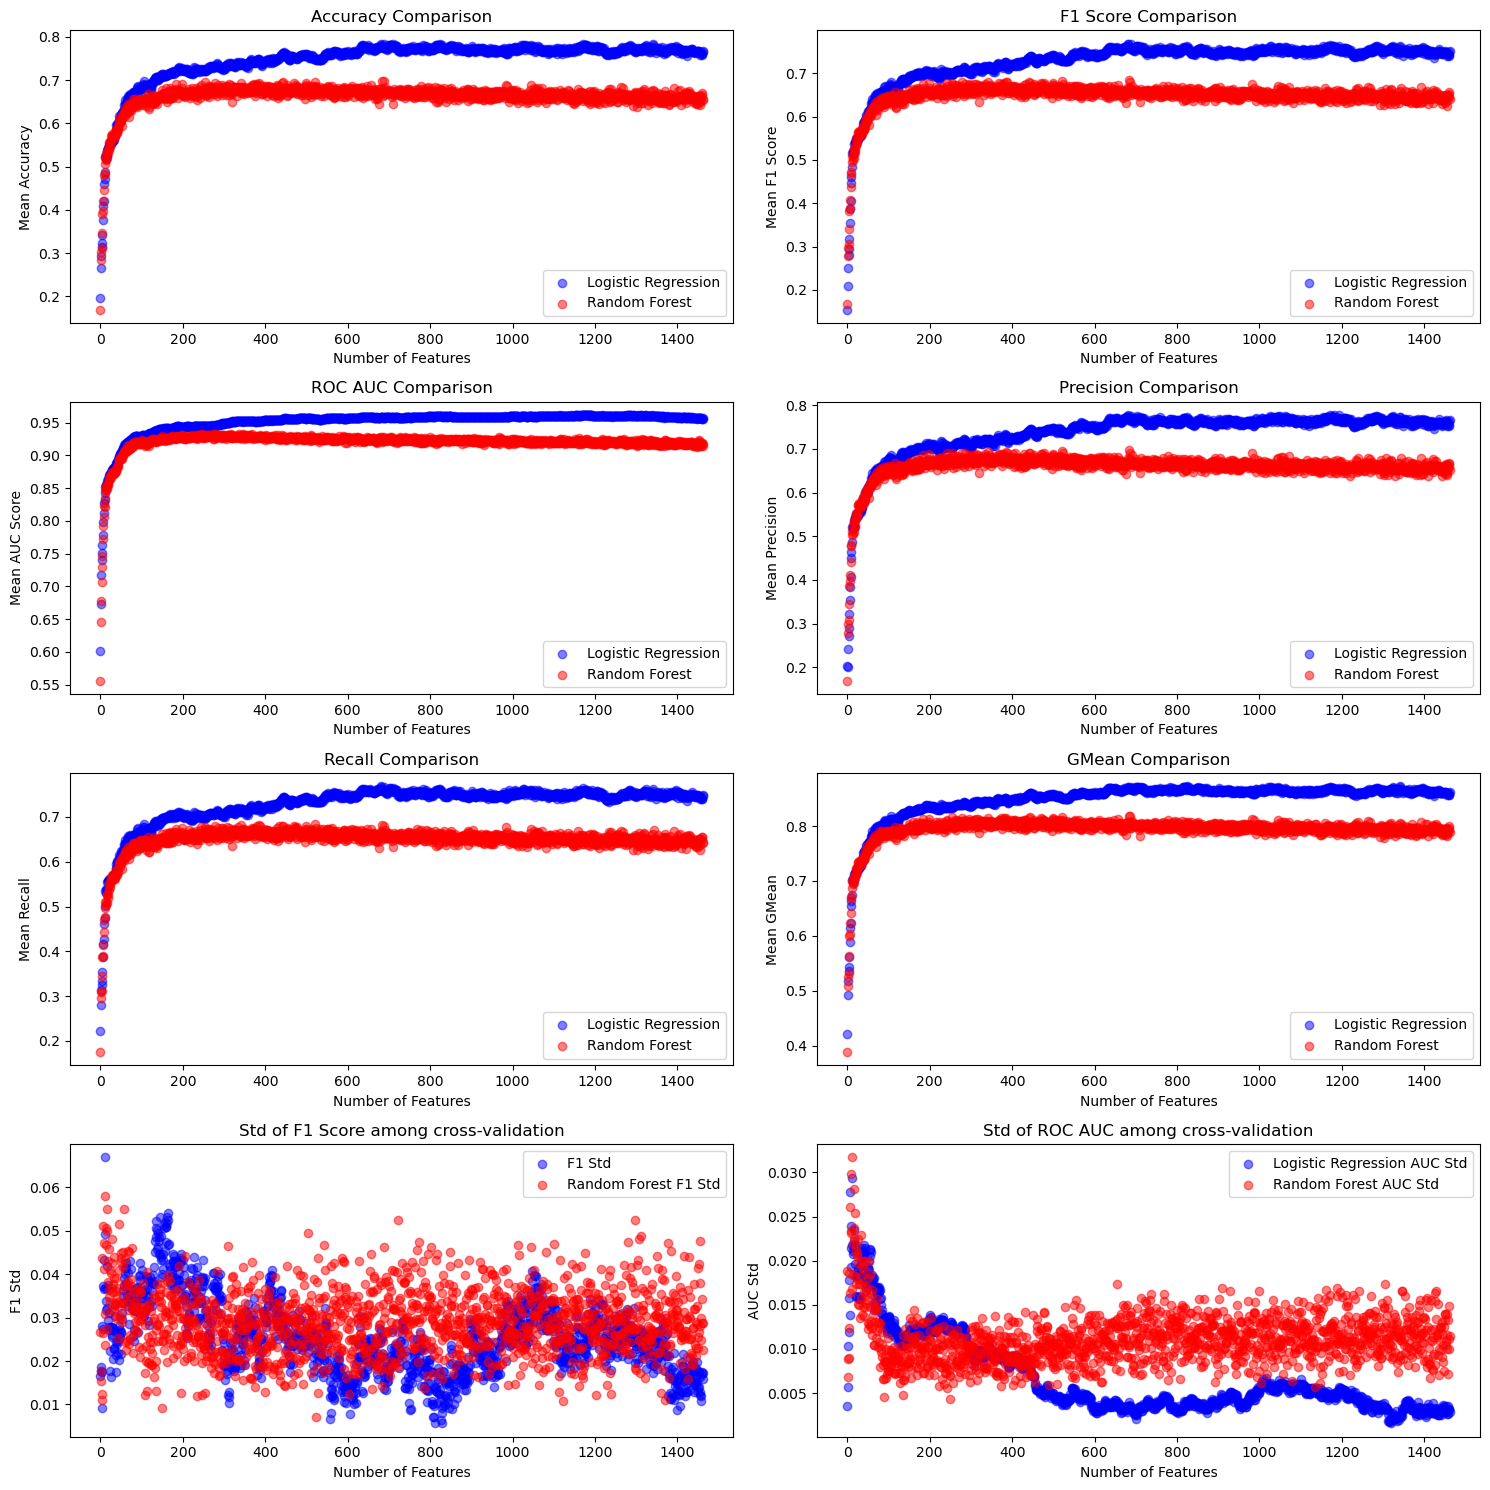

In [24]:
## Further visualization for ALL 1463 features Logistic Regression vs. Random Forest

import matplotlib.pyplot as plt

# Create subplots for comparisons
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Accuracy Comparison (Scatter plot)
axes[0, 0].scatter(range(len(log_accuracy_score_df['Mean'])), log_accuracy_score_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[0, 0].scatter(range(len(rf_accuracy_score_df['Mean'])), rf_accuracy_score_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[0, 0].set_title("Accuracy Comparison")
axes[0, 0].set_xlabel("Number of Features")
axes[0, 0].set_ylabel("Mean Accuracy")
axes[0, 0].legend()

# F1 Score Comparison (Scatter plot)
axes[0, 1].scatter(range(len(log_F1_df['Mean'])), log_F1_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[0, 1].scatter(range(len(rf_F1_df['Mean'])), rf_F1_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[0, 1].set_title("F1 Score Comparison")
axes[0, 1].set_xlabel("Number of Features")
axes[0, 1].set_ylabel("Mean F1 Score")
axes[0, 1].legend()

# AUC Comparison (Scatter plot)
axes[1, 0].scatter(range(len(log_AUC_df['Mean'])), log_AUC_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[1, 0].scatter(range(len(rf_AUC_df['Mean'])), rf_AUC_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[1, 0].set_title("ROC AUC Comparison")
axes[1, 0].set_xlabel("Number of Features")
axes[1, 0].set_ylabel("Mean AUC Score")
axes[1, 0].legend()

# Precision Comparison (Scatter plot)
axes[1, 1].scatter(range(len(log_precision_df['Mean'])), log_precision_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[1, 1].scatter(range(len(rf_precision_df['Mean'])), rf_precision_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[1, 1].set_title("Precision Comparison")
axes[1, 1].set_xlabel("Number of Features")
axes[1, 1].set_ylabel("Mean Precision")
axes[1, 1].legend()

# Recall Comparison (Scatter plot)
axes[2, 0].scatter(range(len(log_recall_df['Mean'])), log_recall_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[2, 0].scatter(range(len(rf_recall_df['Mean'])), rf_recall_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[2, 0].set_title("Recall Comparison")
axes[2, 0].set_xlabel("Number of Features")
axes[2, 0].set_ylabel("Mean Recall")
axes[2, 0].legend()

# GMean Comparison (Scatter plot)
axes[2, 1].scatter(range(len(log_gmean_df['Mean'])), log_gmean_df['Mean'], label="Logistic Regression", color="blue", alpha=0.5)
axes[2, 1].scatter(range(len(rf_gmean_df['Mean'])), rf_gmean_df['Mean'], label="Random Forest", color="red", alpha=0.5)
axes[2, 1].set_title("GMean Comparison")
axes[2, 1].set_xlabel("Number of Features")
axes[2, 1].set_ylabel("Mean GMean")
axes[2, 1].legend()

# Plot for Logistic Regression: Std of F1 Score
axes[3, 0].scatter(range(len(log_F1_df['Std'])), log_F1_df['Std'], color='blue', alpha=0.5, label='F1 Std')
axes[3, 0].scatter(range(len(rf_F1_df['Std'])), rf_F1_df['Std'], color='red', alpha=0.5, label='Random Forest F1 Std')
axes[3, 0].set_title("Std of F1 Score among cross-validation")
axes[3, 0].set_xlabel("Number of Features")
axes[3, 0].set_ylabel("F1 Std")
axes[3, 0].legend()

# Plot for Logistic Regression: Std of AUC
axes[3, 1].scatter(range(len(log_AUC_df['Std'])), log_AUC_df['Std'], color='blue', alpha=0.5, label='Logistic Regression AUC Std')
axes[3, 1].scatter(range(len(rf_AUC_df['Std'])), rf_AUC_df['Std'], color='red', alpha=0.5, label='Random Forest AUC Std')
axes[3, 1].set_title("Std of ROC AUC among cross-validation")
axes[3, 1].set_xlabel("Number of Features")
axes[3, 1].set_ylabel("AUC Std")
axes[3, 1].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Number of CPU cores available: 10


/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/nihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 doe

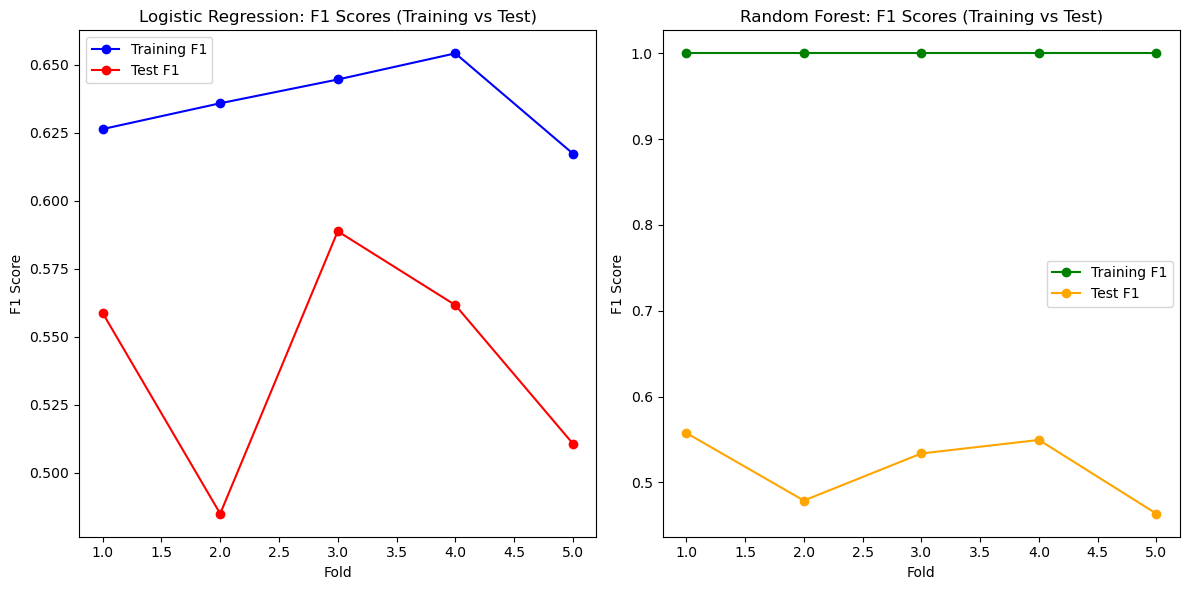

Total running time: 9.10 seconds


In [30]:
## Training vs Test


start_time = time.time()
# Check number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

# Set n_jobs based on available CPU cores (adjust as needed)
n_jobs = num_cores if num_cores > 4 else 4  # Use all cores if > 4, else use 4 for stability

# Define the KNN imputer and SMOTE (they should be defined globally or passed inside)
imputer = KNNImputer(n_neighbors=5, weights="uniform")
smote = SMOTE(random_state=100)

# Define models (Logistic Regression and Random Forest)
models = {
    "Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, n_jobs=n_jobs),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100, n_jobs=n_jobs)
}

# Number of features (proteins)
num_features = len(X_train.columns)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Initialize arrays for F1 Scores (Training and Test) for both models
log_train_F1_scores = np.zeros(5)  # 5 folds
log_test_F1_scores = np.zeros(5)

rf_train_F1_scores = np.zeros(5)
rf_test_F1_scores = np.zeros(5)

# For Logistic Regression and Random Forest models, iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Apply SMOTE
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # Convert to DataFrame for consistency
    resampled_X_df = pd.DataFrame(resampled_X, columns=X_fold_train.columns)
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Feature selection (can be done once outside the loop if features do not change much between folds)
    selector = SelectKBest(score_func=f_classif, k=min(num_features, 20))  # Limit to 20 features for faster execution
    selector.fit(resampled_X_df, resample_y)

    # Get selected features (cache it so we do not need to repeatedly run SelectKBest)
    selected_mask = selector.get_support()
    selected_features = resampled_X_df.columns[selected_mask]

    # Train Logistic Regression
    model = models["Logistic Regression"]
    resampled_X_selected = resampled_X_df[selected_features]
    X_fold_test_selected = X_fold_test_imputed_df[selected_features]
    model.fit(resampled_X_selected, resample_y)

    # Predict and evaluate metrics for Logistic Regression
    y_train_pred = model.predict(resampled_X_selected)
    y_test_pred = model.predict(X_fold_test_selected)

    # Calculate F1 scores for Logistic Regression (Training and Test)
    log_train_F1_scores[fold_idx] = f1_score(resample_y, y_train_pred, average='macro')
    log_test_F1_scores[fold_idx] = f1_score(y_fold_test, y_test_pred, average='macro')

    # Train Random Forest
    model = models["Random Forest"]
    model.fit(resampled_X_selected, resample_y)

    # Predict and evaluate metrics for Random Forest
    y_train_pred = model.predict(resampled_X_selected)
    y_test_pred = model.predict(X_fold_test_selected)

    # Calculate F1 scores for Random Forest (Training and Test)
    rf_train_F1_scores[fold_idx] = f1_score(resample_y, y_train_pred, average='macro')
    rf_test_F1_scores[fold_idx] = f1_score(y_fold_test, y_test_pred, average='macro')

# Now, let's plot the F1 scores for both models

# Plot Logistic Regression: F1 scores for Training vs Test
plt.figure(figsize=(12, 6))

# Logistic Regression Training vs Test F1 Score
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), log_train_F1_scores, label='Training F1', color='blue', marker='o')
plt.plot(range(1, 6), log_test_F1_scores, label='Test F1', color='red', marker='o')
plt.title('Logistic Regression: F1 Scores (Training vs Test)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()

# Random Forest: F1 scores for Training vs Test
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), rf_train_F1_scores, label='Training F1', color='green', marker='o')
plt.plot(range(1, 6), rf_test_F1_scores, label='Test F1', color='orange', marker='o')
plt.title('Random Forest: F1 Scores (Training vs Test)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print the total running time
end_time = time.time()
execution_time = end_time - start_time
print(f"Total running time: {execution_time:.2f} seconds")


Number of CPU cores available: 10
ROC AUC (One-vs-Rest) - Logistic Regression: 0.952
ROC AUC (One-vs-Rest) - Random Forest: 0.919


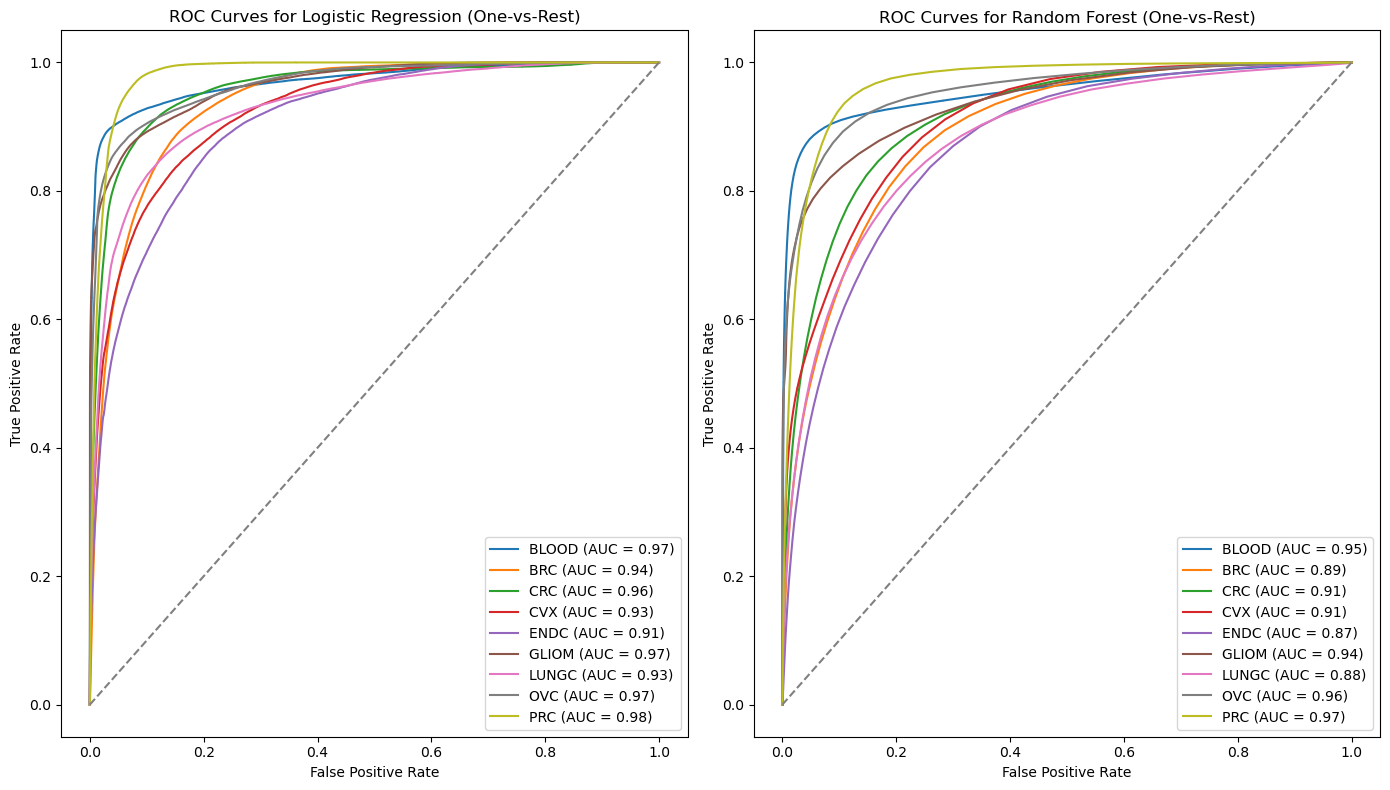

Total running time: 26204.32 seconds


In [29]:
##Roc curve faster code

import time
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, roc_curve, auc



start_time = time.time()

# Check number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

# Set n_jobs based on available CPU cores (adjust as needed)
n_jobs = num_cores if num_cores > 4 else 4  # Use all cores if > 4, else use 4 for stability

# Define the KNN imputer and SMOTE
imputer = KNNImputer(n_neighbors=5, weights="uniform")
smote = SMOTE(random_state=100)

# Define models (Logistic Regression and Random Forest)
models = {
    "Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100)
}

num_features = len(X_train.columns)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Function to train and evaluate models for each fold
def evaluate_fold(fold_idx, train_index, test_index, X_train, y_train, imputer, smote, models, num_features):
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Convert X_fold_test_imputed back to a pandas DataFrame
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Apply SMOTE
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)
    resampled_X = pd.DataFrame(resampled_X, columns=X_fold_train.columns)

    # Initialize storage for predictions and true labels
    log_y_true, log_y_pred_proba = [], []
    rf_y_true, rf_y_pred_proba = [], []

    # Feature selection and model training for each number of features
    for n in range(1, num_features + 1):
        # Select K best features
        selector = SelectKBest(score_func=f_classif, k=n)
        selector.fit(resampled_X, resample_y)

        # Get selected features
        selected_mask = selector.get_support()
        selected_features = resampled_X.columns[selected_mask]

        # Transform training and test data based on selected features
        resampled_X_selected = resampled_X[selected_features]
        X_fold_test_selected = X_fold_test_imputed_df[selected_features]

        # Logistic Regression
        log_model = models["Logistic Regression"]
        log_model.fit(resampled_X_selected, resample_y)
        y_pred_proba_log = log_model.predict_proba(X_fold_test_selected)
        log_y_true.append(y_fold_test)
        log_y_pred_proba.append(y_pred_proba_log)

        # Random Forest
        rf_model = models["Random Forest"]
        rf_model.fit(resampled_X_selected, resample_y)
        y_pred_proba_rf = rf_model.predict_proba(X_fold_test_selected)
        rf_y_true.append(y_fold_test)
        rf_y_pred_proba.append(y_pred_proba_rf)

    # Return results for ROC AUC
    log_y_true = np.concatenate(log_y_true)
    log_y_pred_proba = np.concatenate(log_y_pred_proba)
    rf_y_true = np.concatenate(rf_y_true)
    rf_y_pred_proba = np.concatenate(rf_y_pred_proba)

    return log_y_true, log_y_pred_proba, rf_y_true, rf_y_pred_proba

# Perform parallelized cross-validation using joblib
results = Parallel(n_jobs=n_jobs)(
    delayed(evaluate_fold)(fold_idx, train_index, test_index, X_train, y_train, imputer, smote, models, num_features)
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train))
)

# Unpack results
log_y_true_list, log_y_pred_proba_list, rf_y_true_list, rf_y_pred_proba_list = zip(*results)

# Combine results
log_y_true = np.concatenate(log_y_true_list)
log_y_pred_proba = np.concatenate(log_y_pred_proba_list)
rf_y_true = np.concatenate(rf_y_true_list)
rf_y_pred_proba = np.concatenate(rf_y_pred_proba_list)

# Compute ROC AUC score for multiclass
roc_auc_log = roc_auc_score(log_y_true, log_y_pred_proba, multi_class='ovr', average='weighted')
roc_auc_rf = roc_auc_score(rf_y_true, rf_y_pred_proba, multi_class='ovr', average='weighted')

print(f"ROC AUC (One-vs-Rest) - Logistic Regression: {roc_auc_log:.3f}")
print(f"ROC AUC (One-vs-Rest) - Random Forest: {roc_auc_rf:.3f}")

# Compute ROC curves for Logistic Regression
fpr_log, tpr_log, roc_auc_log_list = {}, {}, {}
for i in range(log_y_pred_proba.shape[1]):
    fpr_log[i], tpr_log[i], _ = roc_curve(log_y_true, log_y_pred_proba[:, i], pos_label=i)
    roc_auc_log_list[i] = auc(fpr_log[i], tpr_log[i])

# Compute ROC curves for Random Forest
fpr_rf, tpr_rf, roc_auc_rf_list = {}, {}, {}
for i in range(rf_y_pred_proba.shape[1]):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(rf_y_true, rf_y_pred_proba[:, i], pos_label=i)
    roc_auc_rf_list[i] = auc(fpr_rf[i], tpr_rf[i])

# Define class names based on the provided information
class_names = ['BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot ROC curves for Logistic Regression (Left plot)
for i in range(len(class_names)):
    axes[0].plot(fpr_log[i], tpr_log[i], label=f'{class_names[i]} (AUC = {roc_auc_log_list[i]:.2f})')

axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Logistic Regression (One-vs-Rest)')
axes[0].legend(loc='lower right')

# Plot ROC curves for Random Forest (Right plot)
for i in range(len(class_names)):
    axes[1].plot(fpr_rf[i], tpr_rf[i], label=f'{class_names[i]} (AUC = {roc_auc_rf_list[i]:.2f})')

axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Random Forest (One-vs-Rest)')
axes[1].legend(loc='lower right')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Calculate and print the total running time
end_time = time.time()
execution_time = end_time - start_time
print(f"Total running time: {execution_time:.2f} seconds")

In [ ]:
## Hyperparameters and GridSearch for Training vs Test but this runs too slow


from sklearn.model_selection import GridSearchCV


# Check number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

# Set n_jobs based on available CPU cores (adjust as needed)
n_jobs = num_cores if num_cores > 4 else 4  # Use all cores if > 4, else use 4 for stability

# Define the KNN imputer and SMOTE (they should be defined globally or passed inside)
imputer = KNNImputer(n_neighbors=5, weights="uniform")
smote = SMOTE(random_state=100)

# Define models (Logistic Regression and Random Forest)
models = {
    "Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=100)
}

# Hyperparameter grid for Random Forest to reduce overfitting
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [10, 20, None],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
}

# Set the number of features to use (50 features)
num_features = 50

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Initialize arrays for F1 Scores (Training and Test) for both models
log_train_F1_scores = np.zeros(5)  # 5 folds
log_test_F1_scores = np.zeros(5)

rf_train_F1_scores = np.zeros(5)
rf_test_F1_scores = np.zeros(5)

# For Logistic Regression and Random Forest models, iterate over the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Convert X_fold_test_imputed back to a pandas DataFrame
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Apply SMOTE
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # Convert resampled_X back to a pandas DataFrame
    resampled_X = pd.DataFrame(resampled_X, columns=X_fold_train.columns)

    # Select K Best features (fixed to num_features=50)
    selector = SelectKBest(score_func=f_classif, k=num_features)
    selector.fit(resampled_X, resample_y)

    # Get selected features
    selected_mask = selector.get_support()
    selected_features = resampled_X.columns[selected_mask]

    # Transform training and test data based on selected features
    resampled_X_selected = resampled_X[selected_features]
    X_fold_test_selected = X_fold_test_imputed_df[selected_features]

    # Train Logistic Regression
    model = models["Logistic Regression"]
    model.fit(resampled_X_selected, resample_y)

    # Predict and evaluate metrics for Logistic Regression
    y_train_pred = model.predict(resampled_X_selected)
    y_test_pred = model.predict(X_fold_test_selected)

    # Calculate F1 scores for Logistic Regression (Training and Test)
    log_train_F1_scores[fold_idx] = f1_score(resample_y, y_train_pred, average='macro')
    log_test_F1_scores[fold_idx] = f1_score(y_fold_test, y_test_pred, average='macro')

    # Perform Grid Search to tune Random Forest hyperparameters
    rf_model = models["Random Forest"]
    grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=n_jobs, scoring='f1_macro')
    grid_search.fit(resampled_X_selected, resample_y)

    # Best model from GridSearchCV
    best_rf_model = grid_search.best_estimator_

    # Predict and evaluate metrics for Random Forest
    y_train_pred_rf = best_rf_model.predict(resampled_X_selected)
    y_test_pred_rf = best_rf_model.predict(X_fold_test_selected)

    # Calculate F1 scores for Random Forest (Training and Test)
    rf_train_F1_scores[fold_idx] = f1_score(resample_y, y_train_pred_rf, average='macro')
    rf_test_F1_scores[fold_idx] = f1_score(y_fold_test, y_test_pred_rf, average='macro')

# Now, let's plot the F1 scores for both models

# Plot Logistic Regression: F1 scores for Training vs Test
plt.figure(figsize=(12, 6))

# Logistic Regression Training vs Test F1 Score
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), log_train_F1_scores, label='Training F1', color='blue', marker='o')
plt.plot(range(1, 6), log_test_F1_scores, label='Test F1', color='red', marker='o')
plt.title('Logistic Regression: F1 Scores (Training vs Test)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()

# Random Forest: F1 scores for Training vs Test
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), rf_train_F1_scores, label='Training F1', color='green', marker='o')
plt.plot(range(1, 6), rf_test_F1_scores, label='Test F1', color='orange', marker='o')
plt.title('Random Forest: F1 Scores (Training vs Test)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
##Hyperparameters and GridSearch for Random Forest, but runs too slow

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Record the start time
start_time = time.time()


# k-Fold Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

#num_features = X_train.shape[1]  # Number of features in the dataset
num_features ==50
num_splits = 5  # Number of K-fold splits

# Initialize score arrays
log_accuracy_score = np.zeros((num_features, num_splits))
log_F1 = np.zeros((num_features, num_splits))
log_AUC = np.zeros((num_features, num_splits))
log_gmean = np.zeros((num_features, num_splits))

rf_accuracy_score = np.zeros((num_features, num_splits))
rf_F1 = np.zeros((num_features, num_splits))
rf_AUC = np.zeros((num_features, num_splits))
rf_gmean = np.zeros((num_features, num_splits))

# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

# Loop over K-folds
for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Convert X_fold_test_imputed back to pandas DataFrame
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=100)
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # Convert resampled_X back to a DataFrame to preserve column names
    resampled_X = pd.DataFrame(resampled_X, columns=X_fold_train.columns)

    # Feature selection for Logistic Regression and Random Forest
    for n in range(1, num_features + 1):  # Feature selection starts at 1
        # Select K best features
        selector = SelectKBest(score_func=f_classif, k=n)
        selector.fit(resampled_X, resample_y)

        # Get selected features
        selected_mask = selector.get_support()
        selected_features = resampled_X.columns[selected_mask]  # Now resampled_X is a DataFrame, so it has columns

        # Transform training and test data based on selected features
        resampled_X_selected = resampled_X[selected_features]
        X_fold_test_selected = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)[selected_features]

        # Train Logistic Regression with 'saga' solver for parallelization
        log_pip = Pipeline([
            ("log", LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, n_jobs=-1))
        ])
        log_pip.fit(resampled_X_selected, resample_y)
        log_y_pred = log_pip.predict(X_fold_test_selected)
        log_y_pred_proba = log_pip.predict_proba(X_fold_test_selected)

        # Logistic Regression metrics
        log_accuracy_score[n - 1, i] = accuracy_score(y_fold_test, log_y_pred)
        log_gmean[n - 1, i] = geometric_mean_score(y_fold_test, log_y_pred, average='weighted')
        log_AUC[n - 1, i] = roc_auc_score(y_fold_test, log_y_pred_proba, multi_class='ovr', average='weighted')
        log_F1[n - 1, i] = f1_score(y_fold_test, log_y_pred, average='macro')

        # Train Random Forest with hyperparameter tuning using GridSearchCV
        rf = RandomForestClassifier(random_state=100, n_jobs=-1)
        rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
        rf_grid_search.fit(resampled_X_selected, resample_y)
        rf_best = rf_grid_search.best_estimator_

        rf_y_pred = rf_best.predict(X_fold_test_selected)
        rf_y_pred_proba = rf_best.predict_proba(X_fold_test_selected)

        # Random Forest metrics
        rf_accuracy_score[n - 1, i] = accuracy_score(y_fold_test, rf_y_pred)
        rf_gmean[n - 1, i] = geometric_mean_score(y_fold_test, rf_y_pred, average='weighted')
        rf_AUC[n - 1, i] = roc_auc_score(y_fold_test, rf_y_pred_proba, multi_class='ovr', average='weighted')
        rf_F1[n - 1, i] = f1_score(y_fold_test, rf_y_pred, average='macro')

# Convert the np.array into DataFrame for further analysis
log_accuracy_score_df = pd.DataFrame(log_accuracy_score)
log_F1_df = pd.DataFrame(log_F1)
log_gmean_df = pd.DataFrame(log_gmean)
log_AUC_df = pd.DataFrame(log_AUC)

rf_accuracy_score_df = pd.DataFrame(rf_accuracy_score)
rf_F1_df = pd.DataFrame(rf_F1)
rf_gmean_df = pd.DataFrame(rf_gmean)
rf_AUC_df = pd.DataFrame(rf_AUC)

# Add mean and std of 5 folds to new columns
log_F1_df['Mean'] = log_F1_df.mean(axis=1)
log_F1_df['Std'] = log_F1_df.std(axis=1)
log_accuracy_score_df['Mean'] = log_accuracy_score_df.mean(axis=1)
log_accuracy_score_df['Std'] = log_accuracy_score_df.std(axis=1)
log_gmean_df['Mean'] = log_gmean_df.mean(axis=1)
log_gmean_df['Std'] = log_gmean_df.std(axis=1)
log_AUC_df['Mean'] = log_AUC_df.mean(axis=1)
log_AUC_df['Std'] = log_AUC_df.std(axis=1)

rf_F1_df['Mean'] = rf_F1_df.mean(axis=1)
rf_F1_df['Std'] = rf_F1_df.std(axis=1)
rf_accuracy_score_df['Mean'] = rf_accuracy_score_df.mean(axis=1)
rf_accuracy_score_df['Std'] = rf_accuracy_score_df.std(axis=1)
rf_gmean_df['Mean'] = rf_gmean_df.mean(axis=1)
rf_gmean_df['Std'] = rf_gmean_df.std(axis=1)
rf_AUC_df['Mean'] = rf_AUC_df.mean(axis=1)
rf_AUC_df['Std'] = rf_AUC_df.std(axis=1)

# Plotting Logistic Regression F1 scores
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(range(len(log_F1_df['Mean'])), log_F1_df['Mean'], color='blue', alpha=0.5, label='AUC')
axes[0].set_title("Logistic Regression: F1 score (Mean)")
axes[0].set_xlabel("Number of Features")
axes[0].set_ylabel("F1 Score")
axes[0].legend()

axes[1].scatter(range(len(log_F1_df['Std'])), log_F1_df['Std'], color='green', alpha=0.5, label='Std')
axes[1].set_title("Logistic Regression: F1 score (Std) Across Cross-Validation")
axes[1].set_xlabel("Number of Features")
axes[1].set_ylabel("Standard Deviation")
axes[1].legend()

plt.show()

# Plotting Random Forest F1 scores
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(range(len(rf_F1_df['Mean'])), rf_F1_df['Mean'], color='blue', alpha=0.5, label='AUC')
axes[0].set_title("Random Forest: F1 score (Mean)")
axes[0].set_xlabel("Number of Features")
axes[0].set_ylabel("F1 Score")
axes[0].legend()

axes[1].scatter(range(len(rf_F1_df['Std'])), rf_F1_df['Std'], color='green', alpha=0.5, label='Std')
axes[1].set_title("Random Forest: F1 score (Std) Across Cross-Validation")
axes[1].set_xlabel("Number of Features")
axes[1].set_ylabel("Standard Deviation")
axes[1].legend()

plt.show()

# Calculate and print the total running time
end_time = time.time()
execution_time = end_time - start_time
print(f"Total running time: {execution_time:.2f} seconds")


